In [1]:
# imports
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import sklearn.metrics as metrics
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

### Overview
Fire and Emergency Medical Services (EMS) department receives many calls. The calls are categorized as EMS or Fire/Other (which are fires, assists, and other events that are not categorized as EMS calls).

A higher priority call is categorized as more urgent (C or D or E) and lower priority is categorized as A or B or Omega. A high-priority EMS call is a Heart Attack, Trouble Breathing, Cardiac Arrest or Serious Injury.  A low-priority EMS call is a minor injury or sickness.  A high-priority Fire / Other Call is a fire, rescue, haz-mat, etc.  A Low-priority Fire / Other call is Assist citizen, Details, etc.

### Data Prep
We have two data sources:
1. 2015 publication from dc gov website that will be used a sample and baseline data. It has been parsed and formatted into csv file to mirror data expected from twitter feed.

2. Primary data is collected from twitter feed.

In [2]:
# load 2015 data as sample data
sample_df = pd.read_csv('./sample_twitter_data.csv')
sample_df.head()

,date,total_calls,critical,non_critical,fire,source
0,08/1/2014,512.0,215.0,216.0,81.0,https://twitter.com/dcfireems/status/08-1-2014
1,08/2/2014,513.0,215.0,215.0,83.0,https://twitter.com/dcfireems/status/08-2-2014
2,08/3/2014,516.0,218.0,214.0,84.0,https://twitter.com/dcfireems/status/08-3-2014
3,08/4/2014,516.0,219.0,213.0,84.0,https://twitter.com/dcfireems/status/08-4-2014
4,08/5/2014,517.0,217.0,217.0,83.0,https://twitter.com/dcfireems/status/08-5-2014


In [3]:
# check structure of the data - don't expect any missing data points
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          396 non-null    object 
 1   total_calls   396 non-null    float64
 2   critical      396 non-null    float64
 3   non_critical  396 non-null    float64
 4   fire          396 non-null    float64
 5   source        396 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.7+ KB


In [4]:
# convert date to DATETIME type and move to index
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df = sample_df.set_index('date')
sample_df.head()

,total_calls,critical,non_critical,fire,source
date,,,,,
2014-08-01,512.0,215.0,216.0,81.0,https://twitter.com/dcfireems/status/08-1-2014
2014-08-02,513.0,215.0,215.0,83.0,https://twitter.com/dcfireems/status/08-2-2014
2014-08-03,516.0,218.0,214.0,84.0,https://twitter.com/dcfireems/status/08-3-2014
2014-08-04,516.0,219.0,213.0,84.0,https://twitter.com/dcfireems/status/08-4-2014
2014-08-05,517.0,217.0,217.0,83.0,https://twitter.com/dcfireems/status/08-5-2014


In [5]:
# add ems column = crit + non_crit
sample_df['ems'] = sample_df.critical + sample_df.non_critical
sample_df.head()

,total_calls,critical,non_critical,fire,source,ems
date,,,,,,
2014-08-01,512.0,215.0,216.0,81.0,https://twitter.com/dcfireems/status/08-1-2014,431.0
2014-08-02,513.0,215.0,215.0,83.0,https://twitter.com/dcfireems/status/08-2-2014,430.0
2014-08-03,516.0,218.0,214.0,84.0,https://twitter.com/dcfireems/status/08-3-2014,432.0
2014-08-04,516.0,219.0,213.0,84.0,https://twitter.com/dcfireems/status/08-4-2014,432.0
2014-08-05,517.0,217.0,217.0,83.0,https://twitter.com/dcfireems/status/08-5-2014,434.0


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

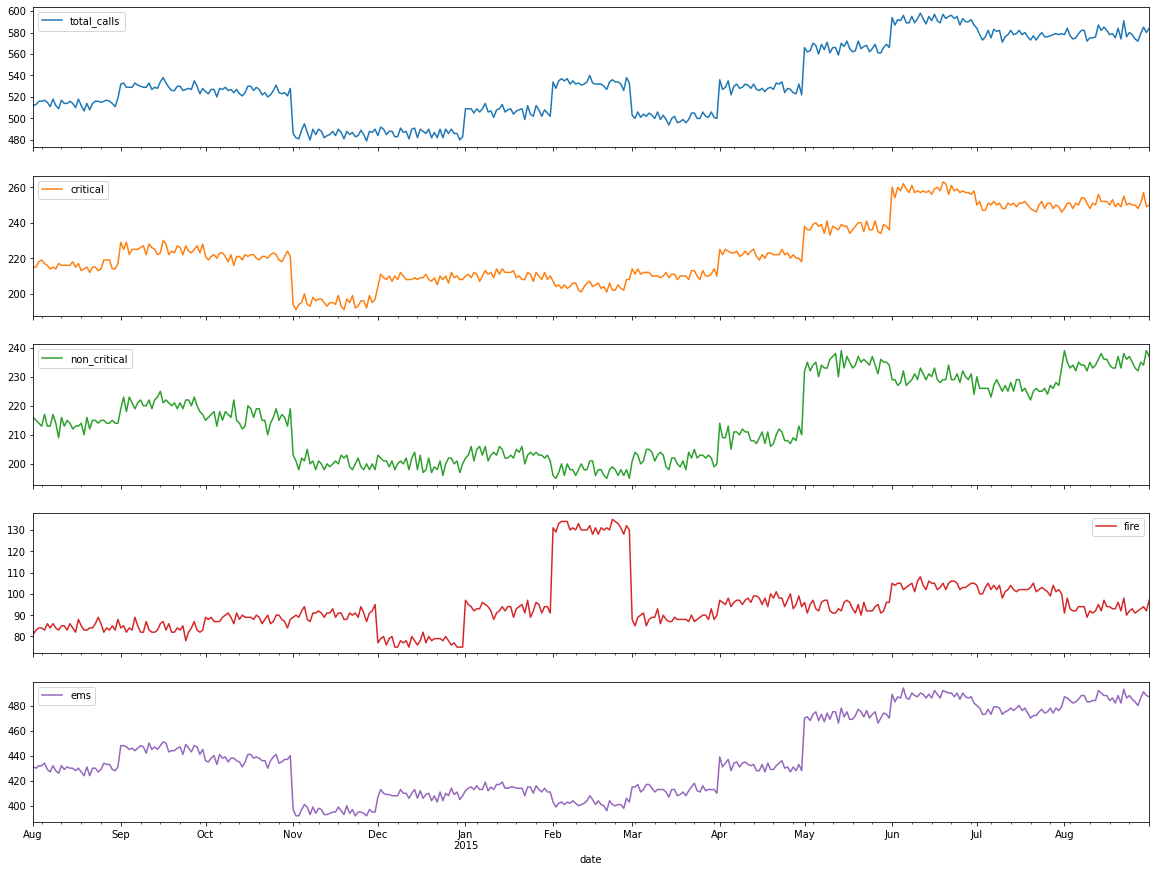

In [6]:
# let's visualize dispatched calls over time
sample_df.plot(subplots=True, figsize=(20, 15))

In [7]:
corr_matrix = sample_df.corr()
corr_matrix.total_calls.sort_values(ascending=False)

total_calls     1.000000
critical        0.938122
ems             0.931908
non_critical    0.865281
fire            0.419431
Name: total_calls, dtype: float64

#### Feature Engineering
Add seasons feature from date column and merge with engineered features from historical weather data.

In [8]:
def get_season(date: datetime) -> str:
    """Return season for given date."""
    year = date.year
    seasons = {
        'summer': (datetime(year, 6, 21), datetime(year, 9, 22)),
        'fall': (datetime(year, 9, 23), datetime(year, 12, 20)),
        'spring': (datetime(year, 3, 21), datetime(year, 6, 20))
    }
    for season, (season_start, season_end) in seasons.items():
        if season_start <= date <= season_end:
            return season
    else:
        return 'winter'

In [9]:
# add season as a feature
sample_df['season'] = sample_df.index.map(get_season)
sample_df.tail(100)

,total_calls,critical,non_critical,fire,source,ems,season
date,,,,,,,
2015-05-24,562.0,236.0,234.0,92.0,https://twitter.com/dcfireems/status/05-24-2015,470.0,spring
2015-05-25,565.0,236.0,237.0,92.0,https://twitter.com/dcfireems/status/05-25-2015,473.0,spring
2015-05-26,569.0,241.0,234.0,94.0,https://twitter.com/dcfireems/status/05-26-2015,475.0,spring
2015-05-27,561.0,235.0,231.0,95.0,https://twitter.com/dcfireems/status/05-27-2015,466.0,spring
2015-05-28,561.0,234.0,236.0,91.0,https://twitter.com/dcfireems/status/05-28-2015,470.0,spring
...,...,...,...,...,...,...,...
2015-08-27,572.0,248.0,232.0,92.0,https://twitter.com/dcfireems/status/08-27-2015,480.0,summer
2015-08-28,579.0,251.0,235.0,93.0,https://twitter.com/dcfireems/status/08-28-2015,486.0,summer
2015-08-29,585.0,257.0,234.0,94.0,https://twitter.com/dcfireems/status/08-29-2015,491.0,summer


In [10]:
# load historical weather data and do some data prep
hist_df = pd.read_csv('./Munged_Washington_2014-08-01_2015-08-31.csv')
hist_df.date = pd.to_datetime(hist_df.date)
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  396 non-null    datetime64[ns]
 1   temp                                  396 non-null    float64       
 2   feels_like                            396 non-null    float64       
 3   pressure                              396 non-null    float64       
 4   humidity                              396 non-null    float64       
 5   wind_speed                            396 non-null    float64       
 6   wind_deg                              396 non-null    float64       
 7   avg_rain                              396 non-null    float64       
 8   avg_snow                              396 non-null    float64       
 9   clouds_all                            396 non-null    float64       
 10  to

In [11]:
# merge sample tweet data with engineered weather data
data_df = pd.merge(sample_df.reset_index(), hist_df, how='left', on='date')
data_df.head()

,date,total_calls,critical,non_critical,fire,source,ems,season,temp,feels_like,...,weather_moderate rain,weather_overcast clouds,weather_scattered clouds,weather_sky is clear,weather_snow,weather_thunderstorm,weather_thunderstorm with heavy rain,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain
0,2014-08-01,512.0,215.0,216.0,81.0,https://twitter.com/dcfireems/status/08-1-2014,431.0,summer,76.485417,77.081667,...,0,1,1,0,0,0,0,0,0,0
1,2014-08-02,513.0,215.0,215.0,83.0,https://twitter.com/dcfireems/status/08-2-2014,430.0,summer,72.086250,72.544583,...,1,1,0,0,0,0,0,0,0,0
2,2014-08-03,516.0,218.0,214.0,84.0,https://twitter.com/dcfireems/status/08-3-2014,432.0,summer,76.405417,77.817500,...,0,1,0,0,0,0,0,0,0,0
3,2014-08-04,516.0,219.0,213.0,84.0,https://twitter.com/dcfireems/status/08-4-2014,432.0,summer,77.496000,78.456400,...,0,1,1,0,0,0,0,1,0,0
4,2014-08-05,517.0,217.0,217.0,83.0,https://twitter.com/dcfireems/status/08-5-2014,434.0,summer,81.150000,81.648750,...,0,0,1,1,0,0,0,0,0,0


### Time Series Prep
The first step in time series model building is to assess stationarity properties, whether mean and vairance is constant over time. The reason being that if we can say that a time series is stationary, we can assume that it has a particular behaviour over time, then there is a high probability that it will follow the same in the future.

#### Analyze Stationarity of EMS and Fire dispatches.
Though we only have a years worth of data in the 2015 data we're using as sample, you can see some seasonality and some slight trend when comparing August 2014 to August 2015 for both EMS and fire dispatches.

For EMS, there seems to be slight trend since there are on average 50 more calls in August 2015 than 2014. You can see somewhat of a seasonal property in that during the winter there's a sharp decrease in dispaches which spikes back up in spring and summer.

For fire, there's a slight trend when comparing August 2014 to 2015 and what looks like some seasonality pattern with a sharp spike in Febraury.

Once we get the real data, we'll hopefully see a more pronounced seasonality and trend patterns when viewed across multiple years.

For assessing stationarity of the time series data, we will use both the Augmented Dickey-Fully (ADF) test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. They both assess stationarity via hypothesis testing. The null hypothesis for the ADF test is "The series has a unit root" implying that the data is non-stationary, rejecting if sufficient evidence to suggest otherwise. KPSS takes the opposite approach, the null hypothesis states that "the process is trend stationary".

Using both tests will ensure that the series is truly stationary and if not, determine the next steps to take to achieve stationarity. The possible outcomes of applying both tests are:

- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

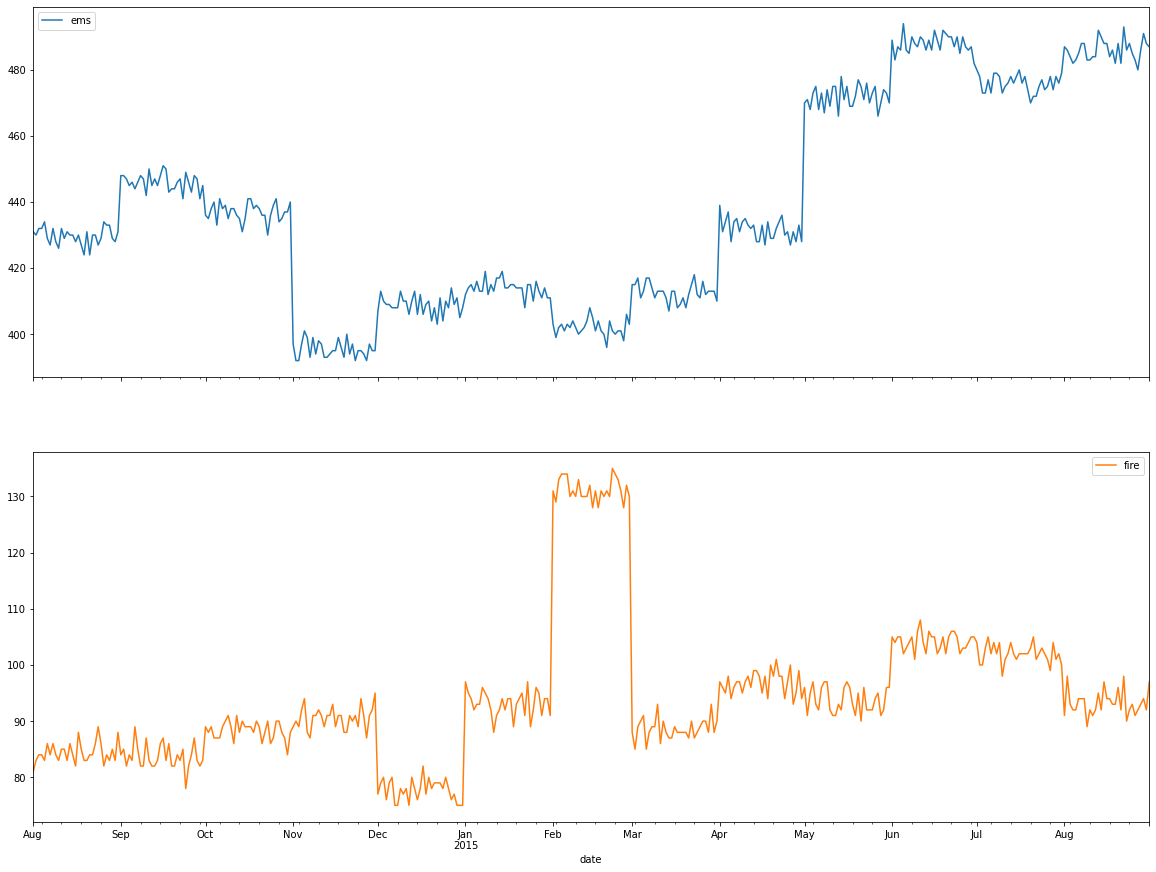

In [12]:
sample_df.loc[:, ['ems', 'fire']].plot(subplots=True, figsize=(20, 15))

In [13]:
# function for testing stationarity analytically
def test_stationarity(ts_df, data_name, window=12,):
    # determine rolling statistics
    rol_mean = ts_df.ewm(halflife=window).mean()
    rol_std = ts_df.ewm(halflife=window).std()
    
    # plot exponentially weighted rolling stats
    plt.figure(figsize=(15, 10))
    plt.plot(ts_df, color='blue', label=data_name)
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Exponentially Weighted Rolling Mean & Standard Deviation for {data_name}')
    plt.show(block=False)
    
    # perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(ts_df, autolag='AIC')
    df_output = pd.Series(
        df_test[0:4],
        index=['Test Statistic', 'p-value', '#Lags Used', 'Num of Observations Used']
    )
    for k, v in df_test[4].items():
        df_output['Critical Value (%s)' %k] = v
    print(df_output)
    
    # perform KPSS test
    print("\nResults of KPSS Test:")
    kpss_test = kpss(ts_df, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpss_test[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_test[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

##### Establishing EMS Stationary Series

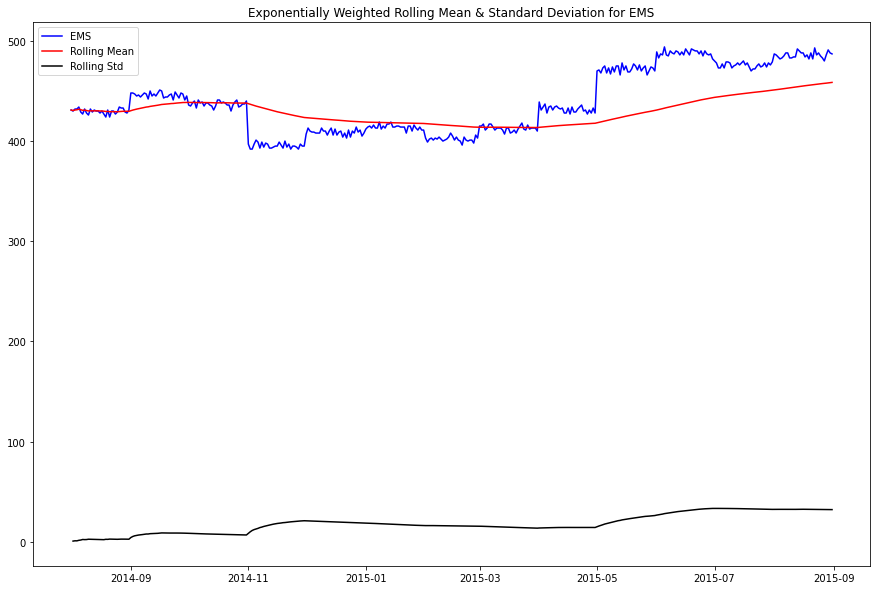

Results of Dickey-Fuller Test:
Test Statistic               -0.783417
p-value                       0.823945
#Lags Used                    1.000000
Num of Observations Used    394.000000
Critical Value (1%)          -3.447057
Critical Value (5%)          -2.868904
Critical Value (10%)         -2.570693
dtype: float64

Results of KPSS Test:
Test Statistic            1.857872
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\kweni\pycharmprojects\dc_ndoch_2021\dc_ndoch_2021_env\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [14]:
test_stationarity(ts_df=sample_df.ems, data_name='EMS', window=90)

ADF for EMS has p-value > 0.05, which means we cannot reject the null hypothesis and such confirming that the series is non-stationary. KPSS has p-value < 0.05 along with Test Statistic greater than 1% critical value, so we can reject the null hypothesis with 99% confidence that the series is non-stationary. So before we can begin with model building we must transform the series until it passes both hypthosis tests.

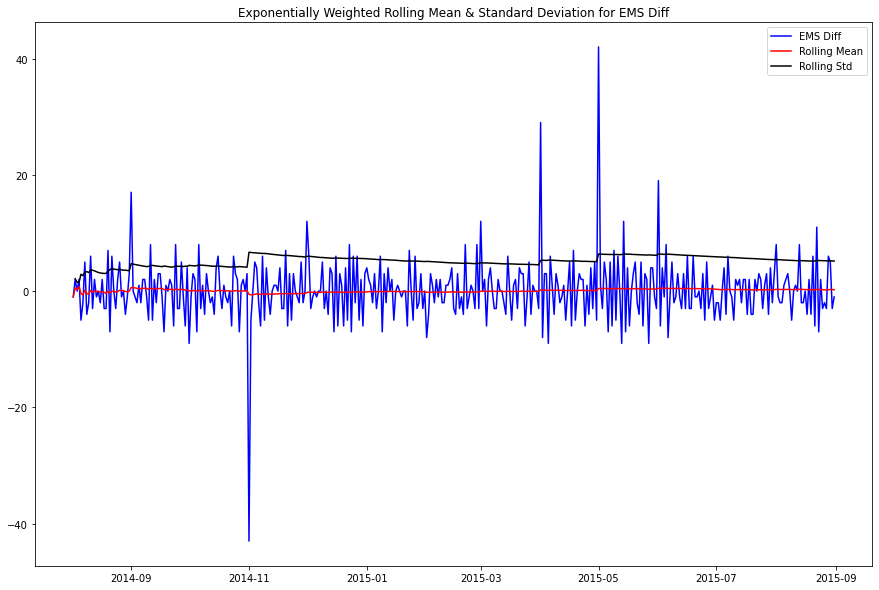

Results of Dickey-Fuller Test:
Test Statistic              -26.868502
p-value                       0.000000
#Lags Used                    0.000000
Num of Observations Used    394.000000
Critical Value (1%)          -3.447057
Critical Value (5%)          -2.868904
Critical Value (10%)         -2.570693
dtype: float64

Results of KPSS Test:
Test Statistic           0.187419
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\users\kweni\pycharmprojects\dc_ndoch_2021\dc_ndoch_2021_env\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [15]:
# Perform differencing
ems_shift = sample_df.ems - sample_df.ems.shift()
ems_shift.dropna(inplace=True)
test_stationarity(ts_df=ems_shift, data_name='EMS Diff', window=90)

After performing first order differencing we now have a stationary series:
- ADF has p-value = 0 with test statistic greater than 1% critical value, which means with 99% confidence we can reject the null hypothesis that the series has a unit root i.e. non-stationary.
- KPSS has p-value > 0.05 which means we cannot reject the non-hypothesis that the series is trend stationary.

##### Establishing Fire Stationary Series

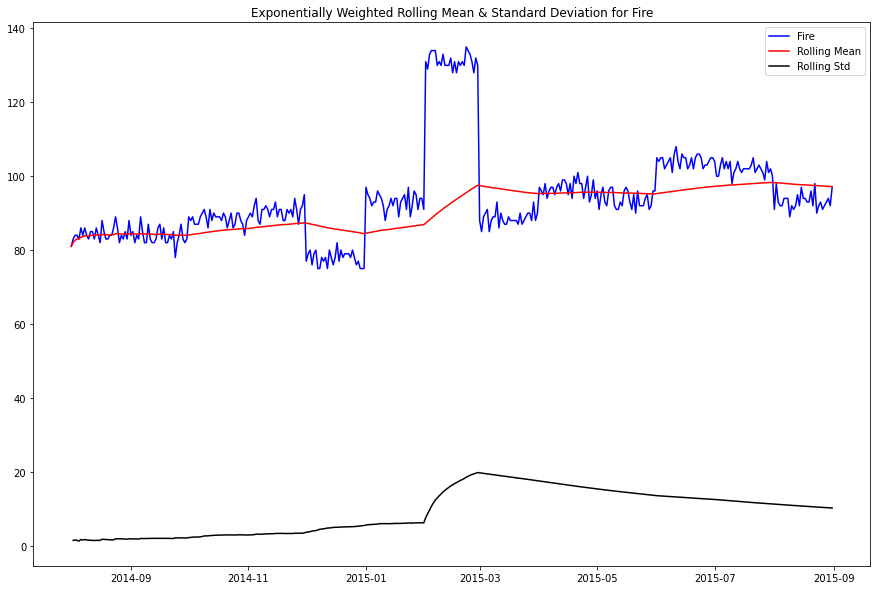

Results of Dickey-Fuller Test:
Test Statistic               -2.908267
p-value                       0.044395
#Lags Used                    1.000000
Num of Observations Used    394.000000
Critical Value (1%)          -3.447057
Critical Value (5%)          -2.868904
Critical Value (10%)         -2.570693
dtype: float64

Results of KPSS Test:
Test Statistic            0.832166
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\kweni\pycharmprojects\dc_ndoch_2021\dc_ndoch_2021_env\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [16]:
test_stationarity(ts_df=sample_df.fire, data_name='Fire', window=90)

ADF for Fire series has p-value < 0.05 along with Test Statistic greater than 5% critical value, which means we can reject the null hypothesis and such confirming that the series is stationary. KPSS has p-value < 0.05 along with Test Statistic greater than 1% critical value, so we must reject the null hypothesis; which contrary to ADF, confirming that the series is non-stationary.

Since ADF indicates stationary, while KPSS indicates non-stationary, we have an example of case 4 noted earlier; the series is difference stationary. So before we can begin with model building we will implement differencing on the Fire series to make it a stationary series.

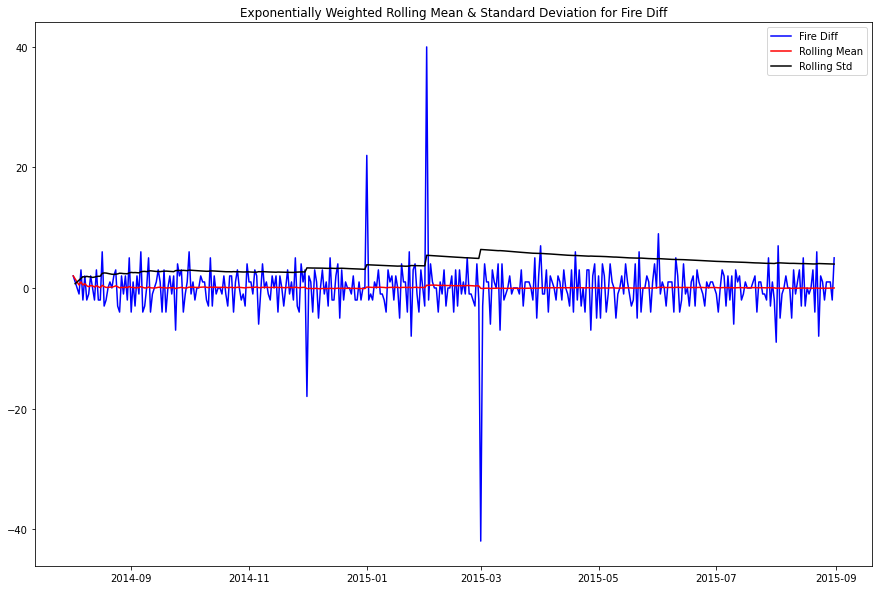

Results of Dickey-Fuller Test:
Test Statistic              -24.303746
p-value                       0.000000
#Lags Used                    0.000000
Num of Observations Used    394.000000
Critical Value (1%)          -3.447057
Critical Value (5%)          -2.868904
Critical Value (10%)         -2.570693
dtype: float64

Results of KPSS Test:
Test Statistic           0.035263
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\users\kweni\pycharmprojects\dc_ndoch_2021\dc_ndoch_2021_env\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [17]:
# Perform differencing
fire_shift = sample_df.fire - sample_df.fire.shift()
fire_shift.dropna(inplace=True)
test_stationarity(ts_df=fire_shift, data_name='Fire Diff', window=90)

After performing first order differencing we now have a stationary series:
- ADF has p-value = 0 with test statistic greater than 1% critical value, which means with 99% confidence we can reject the null hypothesis that the series has a unit root i.e. non-stationary.
- KPSS has p-value > 0.05 which means we cannot reject the non-hypothesis that the series is trend stationary.

### Forcasting EMS and Fire Series

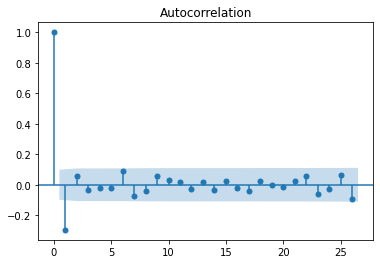

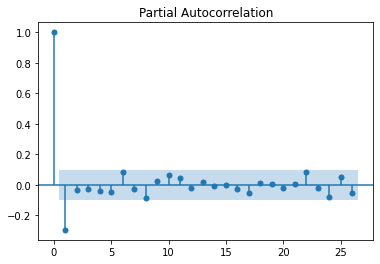

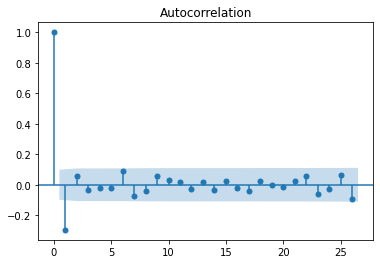

In [21]:
plot_pacf(ems_shift)
plot_acf(ems_shift)

In [22]:
ems_model = ARIMA(ems_shift, order=(1, 1, 1)).fit(disp=-1)
ems_model.summary()

c:\users\kweni\pycharmprojects\dc_ndoch_2021\dc_ndoch_2021_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\kweni\pycharmprojects\dc_ndoch_2021\dc_ndoch_2021_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: Valu

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.ems   No. Observations:                  394
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1204.965
Method:                       css-mle   S.D. of innovations              5.109
Date:                Sun, 26 Sep 2021   AIC                           2417.931
Time:                        00:12:01   BIC                           2433.836
Sample:                    08-03-2014   HQIC                          2424.233
                         - 08-31-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0016      0.002      0.903      0.367      -0.002       0.005
ar.L1.D.ems    -0.2952      0.048     -6.141      0.000      -0.389      -0.201
ma.L1.D.ems    -0.9999      0.008   -130.920      0.000      -1.015      -0.985
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3879           +0.0000j            3.3879            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

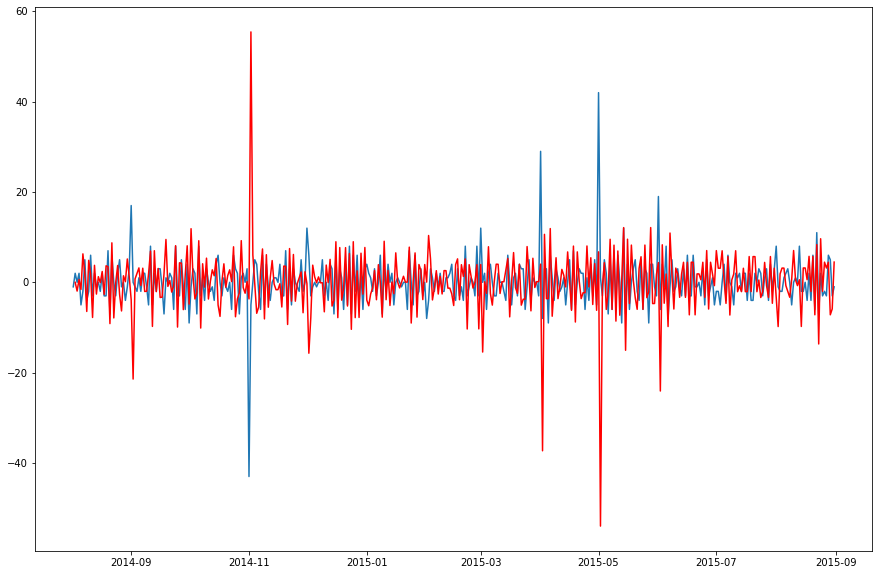

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(ems_shift)
plt.plot(ems_model.fittedvalues, color='red')